In [1]:
# Code that helps avoid overusing memory

import tensorflow as tf
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)
from keras import backend as K
K.set_session(sess)

/home/kaiolae/.virtualenvs/worldmodels/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML


def plot_movie_mp4(image_array):
    dpi = 36.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    #fig = plt.figure(figsize=(100,100), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(HTML(anim.to_html5_video()))

In [3]:
import os
import sys


#Adding WorldModels path to pythonpath
nb_dir = os.path.split(os.getcwd())[0]
print(nb_dir)
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
#Importing the VAE
from VAE.world_model_vae import VAE

/home/kaiolae/code/word_models_keras_test/WorldModels


In [4]:
#Loading Weights of trained VAE
vae = VAE()
vae.set_weights("../vae_model_64_dim/final_full_vae_weights.h5")

VAE init
Shape before flattening: (None, 16, 16, 32)
KL Shape: (None,)
Xent shape: ()
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 3)    39          encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   416         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 32)   4128        conv2d_2[0][0]                   
_______________________

In [5]:
#Getting some data to feed into the VAE
import numpy as np
data = np.load("../data_small_episodes/obs_data_doomrnn_1.npy")


(100,)


[]

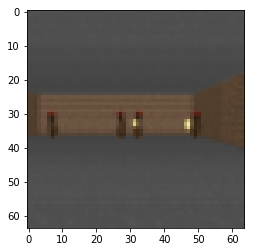

In [6]:
#Data: Dimensions are (rollout, timestep, x-axis, y-axis, colors)
print(data.shape)

selected_rollout = np.array(data[2])
selected_rollout = selected_rollout.astype('float32') / 255.
#print(selected_rollout.shape)

some_picture = selected_rollout[200]
some_picture.shape
plt.imshow(some_picture)
plt.plot()

In [7]:
#Testing reconstructing the data with the VAE
latent_values_for_rollout = vae.encoder.predict(np.array(selected_rollout))
latent_values_for_rollout.shape
#Cool! We can prove that we're actually compressing things here simply by looking at the shape of the latent variables.

(300, 64)

(300, 64, 64, 3)
[[[0.37508106 0.3714416  0.37551934]
  [0.37243548 0.3712541  0.37412712]
  [0.3731875  0.3753745  0.37544614]
  ...
  [0.36991504 0.3724081  0.37350345]
  [0.3686116  0.37195346 0.3722185 ]
  [0.37202418 0.37236837 0.372061  ]]

 [[0.3779264  0.376672   0.37718078]
  [0.377623   0.3776086  0.3759322 ]
  [0.3749532  0.3743117  0.3743618 ]
  ...
  [0.375441   0.37571484 0.37540329]
  [0.37478197 0.375095   0.37502632]
  [0.3746182  0.37295035 0.37251377]]

 [[0.37827376 0.37608626 0.37322623]
  [0.37176156 0.371764   0.37048784]
  [0.37094063 0.3713272  0.37200695]
  ...
  [0.3715704  0.37232324 0.37263313]
  [0.3726061  0.3719568  0.37267575]
  [0.3726126  0.37221277 0.37377423]]

 ...

 [[0.3710004  0.36901778 0.37154308]
  [0.37208715 0.37140813 0.37199923]
  [0.37237826 0.37231907 0.37295142]
  ...
  [0.37063584 0.3704838  0.37141788]
  [0.37160844 0.3706203  0.3702824 ]
  [0.37181106 0.36808562 0.3672057 ]]

 [[0.37050158 0.37102532 0.37028205]
  [0.36867    0.3707

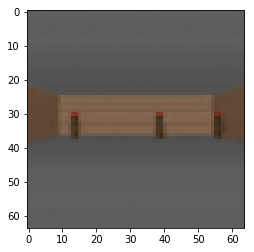

In [8]:
regenerated_images = vae.decoder.predict(latent_values_for_rollout)
print(regenerated_images.shape)
plt.imshow(regenerated_images[0])
print(regenerated_images[2])

In [9]:
plot_movie_mp4(selected_rollout)
plot_movie_mp4(regenerated_images)

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

In [10]:
!pip install opencv-python

In [11]:
def make_video(images, outvid=None, fps=5, size=None,
               is_color=True, format="XVID"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if vid is None:
            if size is None:
                size = image.shape[1], image.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != image.shape[1] and size[1] != image.shape[0]:
            image = resize(image, size)
        vid.write(image)
    vid.release()
    return vid

make_video(selected_rollout, "input_to_vae.mp4")

error: /io/opencv/modules/videoio/src/cap_ffmpeg.cpp:274: error: (-215) image->depth == 8 in function writeFrame


In [ ]:
#Testing storing as video
import cv2
import os

height, width, layers = 64, 64, 3

video = cv2.VideoWriter("selected_rollout.avi", -1, 1, (width,height))
for image in selected_rollout:
    video.write(image)

cv2.destroyAllWindows()
video.release()